# Demographic Data: Density and Land Development

| ID  | Dataset                     | Description                                                                                     | License | Access                                      |
|-----|-----------------------------|-------------------------------------------------------------------------------------------------|---------|---------------------------------------------|
| 1   |WorldPop - Population Density| Raster data on population density at the square Km level                                        | Open    | [WorldPop](https://dx.doi.org/10.5258/SOTON/WP00674)|
| 2   |Google Open Buildings        |Georeferrenced building detections through satellite imagery and computer vision                 | Open    |[OpenBuildings](https://sites.research.google/gr/open-buildings/)|
| 3   |Subnational Administrative Boundaries|Shapes of administrative boundaries                                                      | Open    |[Sri Lanka](https://data.humdata.org/dataset/cod-ab-lka), [Bangladesh](https://data.humdata.org/dataset/cod-ab-bgd), [India](https://data.humdata.org/dataset/geoboundaries-admin-boundaries-for-india)|

## Units of Analysis

- **Population Density**: For these metrics, the data is acquired from the WorldPop data hub in Geotiff format, with a resolution of 30 arc-seconds; this means that we have about a 1 square Km resolution at the equator. The data is specifically for the year 2020, the most recent update to the database.

- **Built Area**: We aggregate the Google Open Buildings data at the ADM-3 level for each country; that is, the third administrative subdivition under the national boundaries. This is helpful as this data contains a very large amount of observation and information, so aggregation facilitates the analysis process for our goals. Therefor, the metric used is specifically the total built area by administrative subdivition at the ADM-3 level

## Metrics Analyzed

This data contains georeferrenced polygons detected through satellite imagery, as well as centroid points (latitude and longitude) for each polygon, a [Plus Code](https://plus.codes/), a confidence score for the detection, and the area of the polygon in square meters

- Population density by square Km: Unconstrained measure of the population in an area of about 1 Km.

- Built Area by administrative subdivition at the ADM-3 level: Sum of the area of all buildings whose centroid is located within each administrative subdivition.


## Population Density

We use raster data provided by [WorldPop](https://dx.doi.org/10.5258/SOTON/WP00674) to assess differences in population concentrations between the different countries. One of the main diferences we can find is the higher rates of centralization of the population in Bangladesh as compared to Sri Lanka and India. The population of Bangladesh is largely concentrated in Dhaka and, while there maily exists concentration in Colombo for the case of Sri Lanka, the population of the latter and of India seem to also be spread in small- and medium-sized cities. Centralization may indicate lower standards of living in rural areas, as well as worsened public service provitions.

C:\Users\Work\AppData\Local\Temp\ipykernel_7636\184637911.py:96: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lon, centroid_lat = all_shape.centroid[0].coords.xy



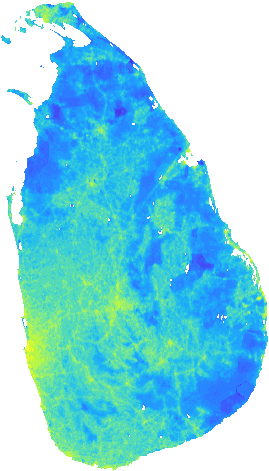
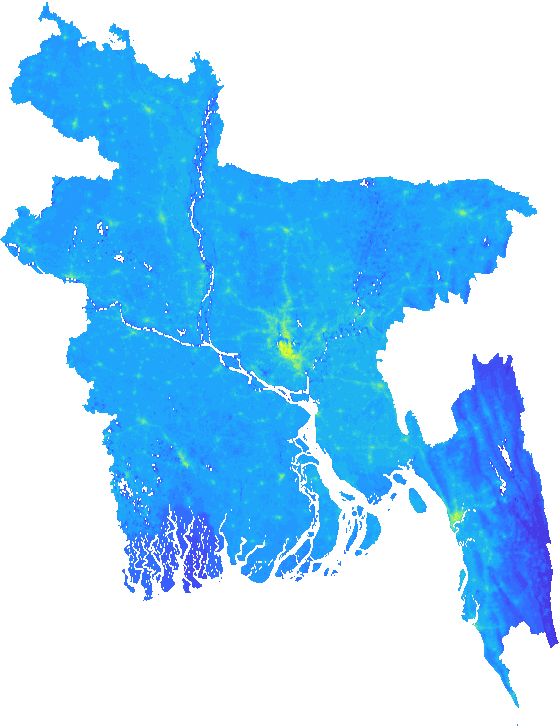
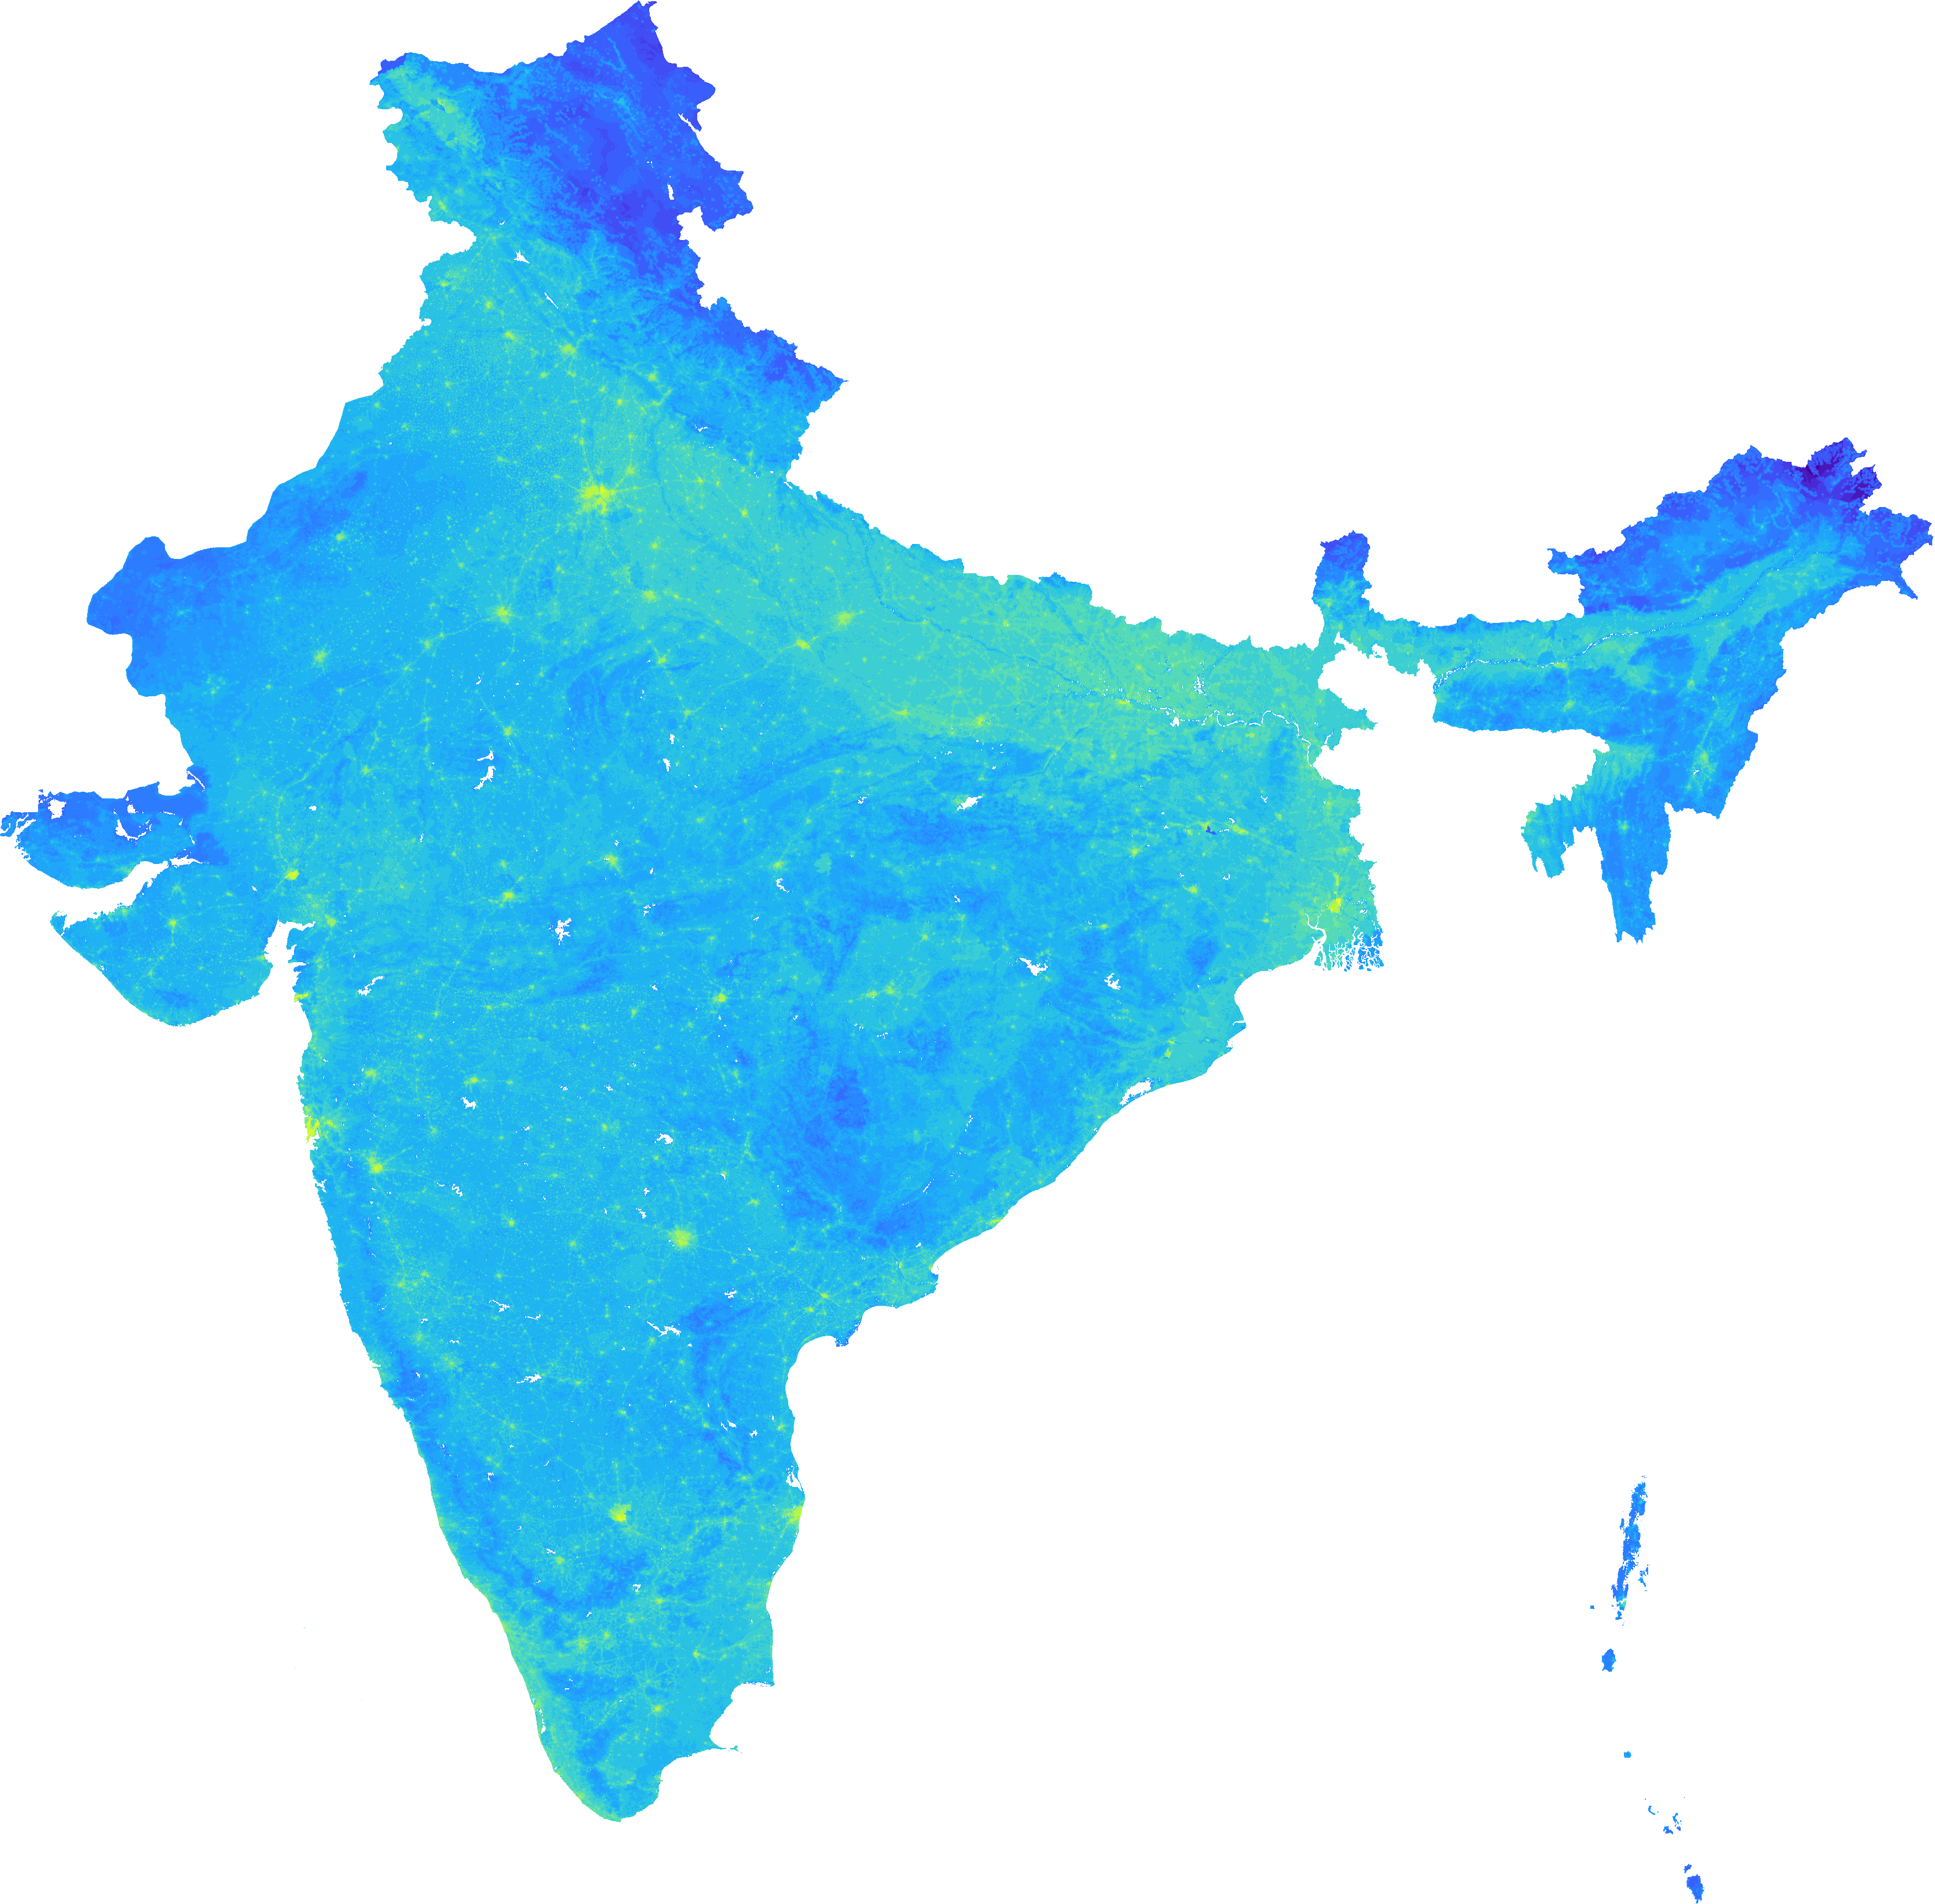

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio import mask
import numpy as np
import shapely as shp
import folium
import branca.colormap as bcm
from matplotlib import colors as colors
from branca.element import MacroElement
from jinja2 import Template

class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)

def define_cmap(image, name):
    processed_image = image[~np.isnan(image)]
    color_map = bcm.StepColormap(
        colors = bcm.linear.viridis.colors,
        vmin = processed_image.min(),
        vmax = processed_image.max(),
        caption = name
    )
    return color_map

def mapvalue2color(value, cmap): 
    """
    Map a pixel value of image to a color in the rgba format. 
    As a special case, nans will be mapped totally transparent.
    
    Inputs
        -- value - pixel value of image, could be np.nan
        -- cmap - a linear colormap from branca.colormap.linear
    Output
        -- a color value in the rgba format (r, g, b, a)    
    """
    if np.isnan(value):
        return (1, 0, 0, 0)
    else:
        return colors.to_rgba(cmap(value), 0.7)

lka_admin0_shpfile_path = "_data/raw/lka_adm/lka_admbnda_adm0_slsd_20220816.shp"
lka_pop_density_path = "_data/raw/lka_pd_2020_1km.tif"
bgd_admin0_shpfile_path = "_data/raw/bgd_adm/bgd_admbnda_adm0_bbs_20201113.shp"
bgd_pop_density_path = "_data/raw/bgd_pd_2020_1km.tif"
ind_admin0_shpfile_path = "_data/raw/ind_adm/adm0.shp"
ind_pop_density_path = "_data/raw/ind_pd_2020_1km.tif"

lka_admin_raw = gpd.read_file(lka_admin0_shpfile_path)
lka_density_raw = rio.open(lka_pop_density_path)
lka_bounding_box = lka_density_raw.bounds
lka_bounds = [[lka_bounding_box.bottom, lka_bounding_box.left], [lka_bounding_box.top, lka_bounding_box.right]]
lka_image, lka_transform = mask.mask(lka_density_raw, list(lka_admin_raw["geometry"][0].geoms), nodata = np.nan)
lka_image = lka_image[0]

bgd_admin_raw = gpd.read_file(bgd_admin0_shpfile_path)
bgd_density_raw = rio.open(bgd_pop_density_path)
bgd_bounding_box = bgd_density_raw.bounds
bgd_bounds = [[bgd_bounding_box.bottom, bgd_bounding_box.left], [bgd_bounding_box.top, bgd_bounding_box.right]]
bgd_image, bgd_transform = mask.mask(bgd_density_raw, list(bgd_admin_raw["geometry"][0].geoms), nodata = np.nan)
bgd_image = bgd_image[0]

ind_admin_raw = gpd.read_file(ind_admin0_shpfile_path)
ind_density_raw = rio.open(ind_pop_density_path)
ind_bounding_box = ind_density_raw.bounds
ind_bounds = [[ind_bounding_box.bottom, ind_bounding_box.left], [ind_bounding_box.top, ind_bounding_box.right]]
ind_image, ind_transform = mask.mask(ind_density_raw, list(ind_admin_raw["geometry"][0].geoms), nodata = np.nan)
ind_image = ind_image[0]

all_shape = pd.concat((ind_admin_raw, bgd_admin_raw, lka_admin_raw))
all_shape["all"] = 1
all_shape = all_shape[["all", "geometry"]].dissolve(by = "all").reset_index()
centroid_lon, centroid_lat = all_shape.centroid[0].coords.xy
centroid_lon, centroid_lat = centroid_lon[0], centroid_lat[0]

colormaps = []

for image, title in zip([lka_image, bgd_image, ind_image], ["Sri Lanka", "Bangladesh", "India"]):
    colormaps += [define_cmap(np.log10(image, out=np.zeros_like(image, dtype=np.float64), where=(image!=0)), "Log-Population Density per Square Km - " + title)]

m = folium.Map(location=(centroid_lat, centroid_lon), zoom_start = 5)

for image, title, bounds, cmap in zip([lka_image, bgd_image, ind_image], ["Sri Lanka", "Bangladesh", "India"], [lka_bounds, bgd_bounds, ind_bounds], colormaps):
    overlay = folium.raster_layers.ImageOverlay(np.log10(image, out=np.zeros_like(image, dtype=np.float64), where=(image!=0)), opacity = .5, bounds = bounds, colormap = lambda x: mapvalue2color(x, cmap), name = title, mercator_project=True)
    
    for child in overlay._children:
        if child.startswith("color_map"):
            del overlay._children[child]
    
    m.add_child(cmap)
    m.add_child(overlay)
    overlay_bind = BindColormap(overlay, cmap)
    m.add_child(overlay_bind)

m.add_child(folium.LayerControl())
m

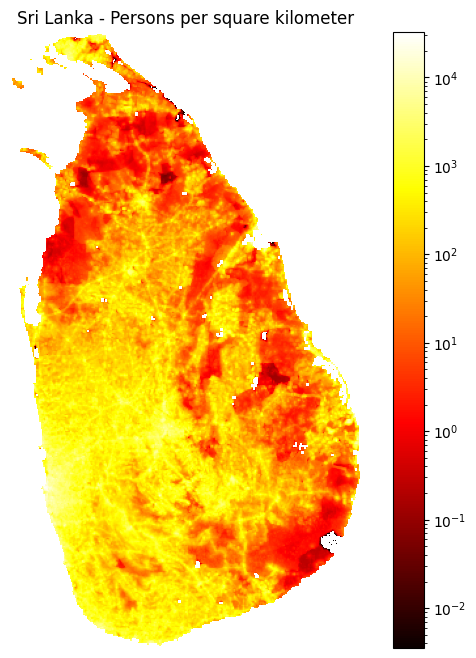

In [2]:
import matplotlib.colors
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8))
lka_image[lka_image == 0] = np.floor(np.nanmin(lka_image[lka_image != 0]))
plt.imshow(lka_image, cmap = "hot", norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.box(False)
plt.axis(False)
plt.title("Sri Lanka - Persons per square kilometer")
plt.show()

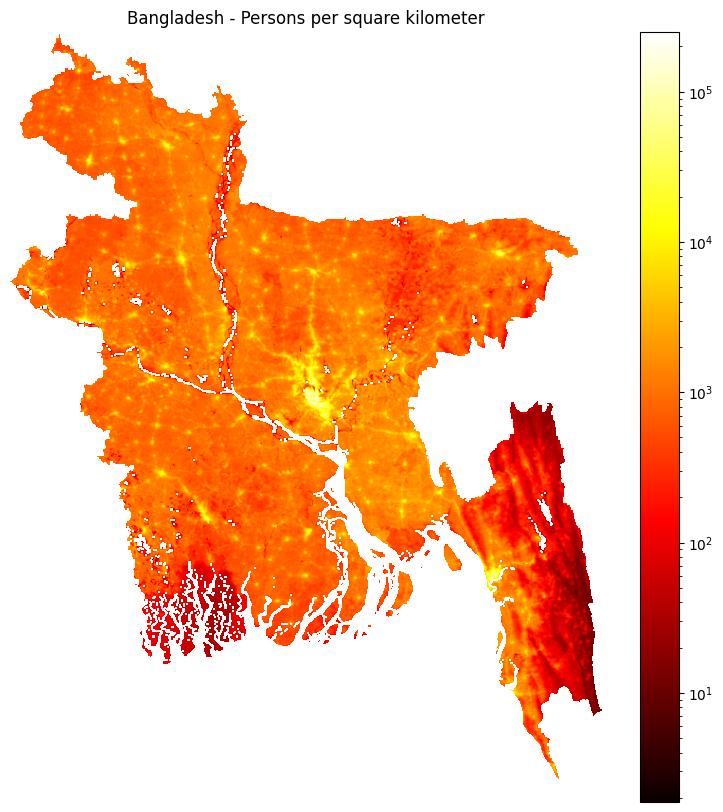

In [3]:
plt.figure(figsize = (10, 10))
bgd_image[bgd_image == 0] = np.floor(np.nanmin(bgd_image[bgd_image != 0]))
plt.imshow(bgd_image, cmap = "hot", norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.box(False)
plt.axis(False)
plt.title("Bangladesh - Persons per square kilometer")
plt.show()

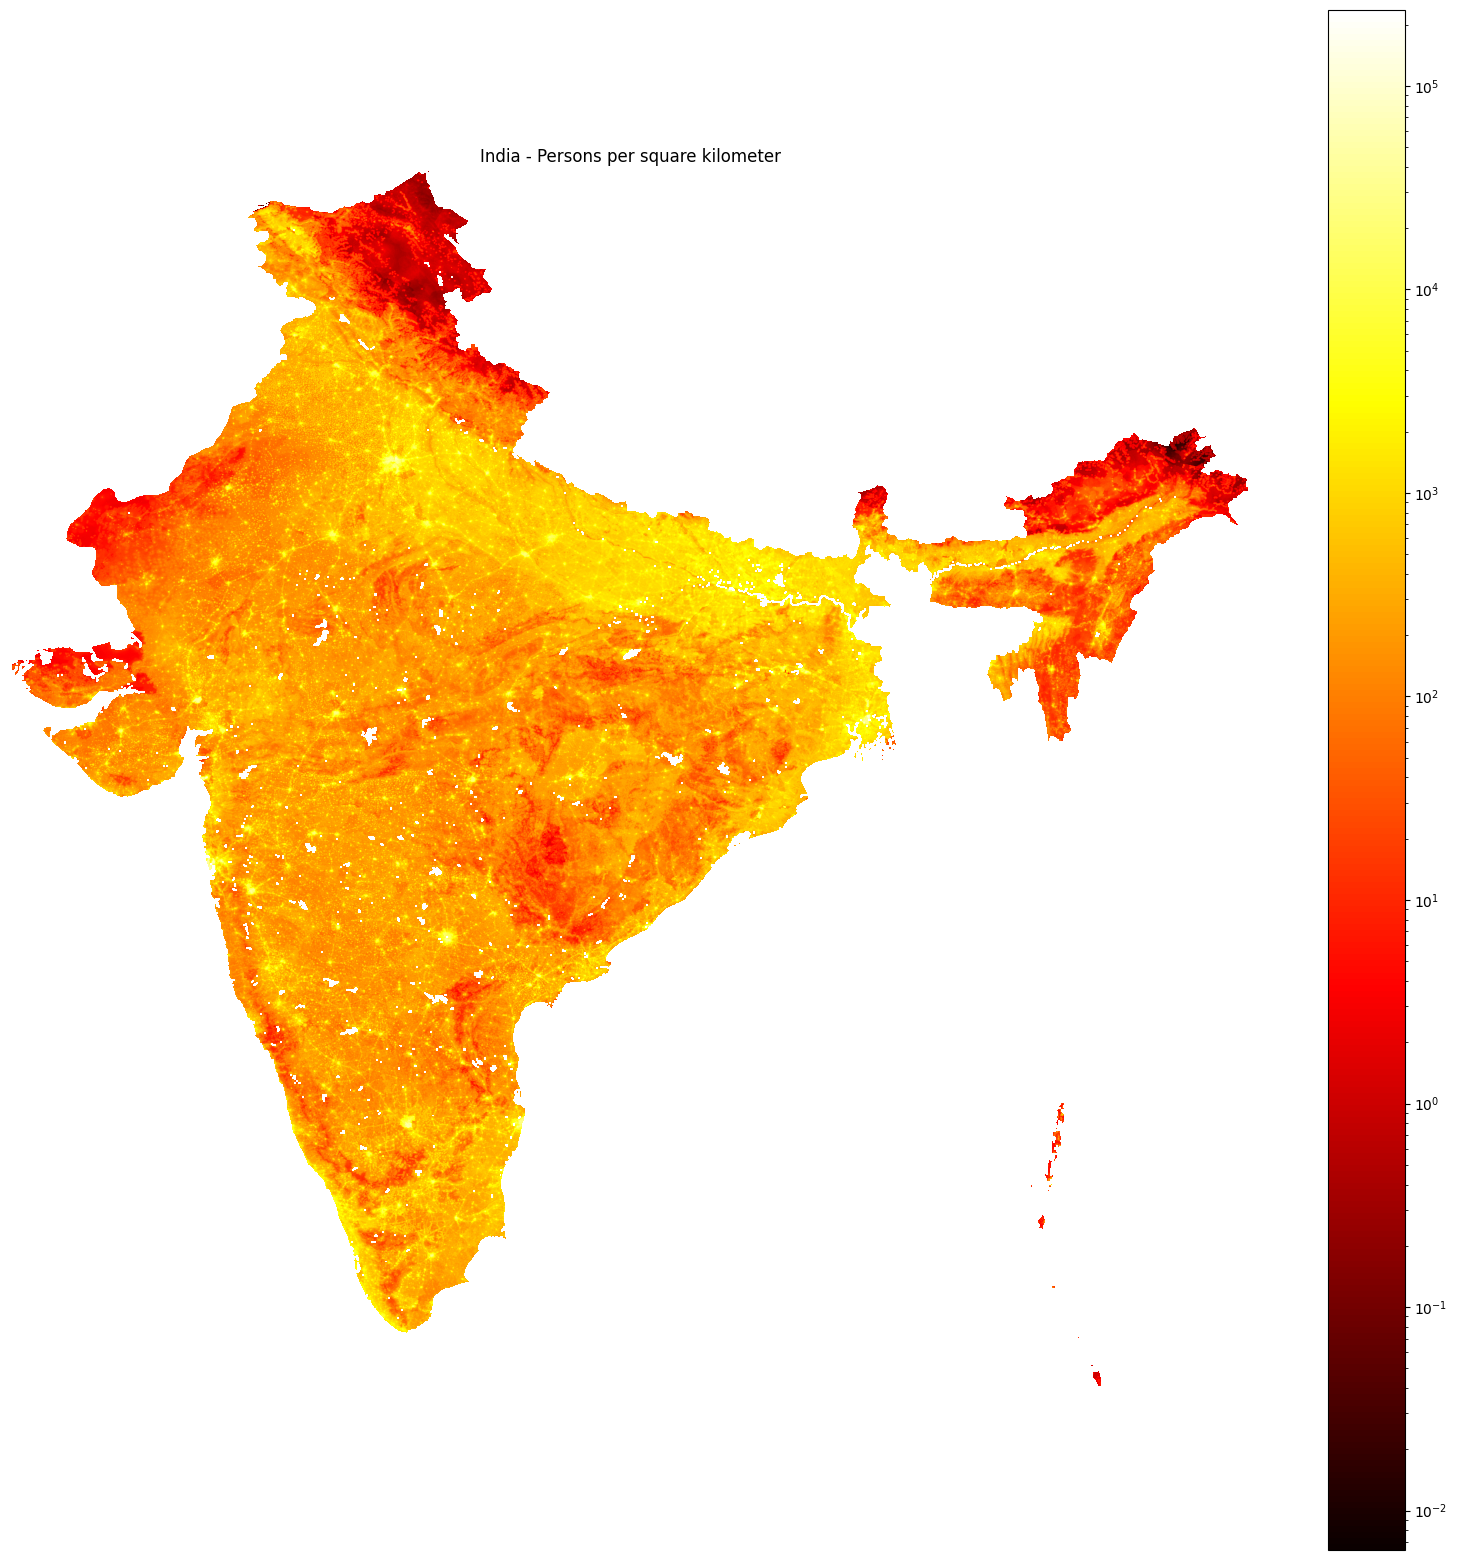

In [4]:
plt.figure(figsize = (20, 20))
ind_image[ind_image == 0] = np.floor(np.nanmin(ind_image[ind_image != 0]))
plt.imshow(ind_image, cmap = "hot", norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.box(False)
plt.axis(False)
plt.title("India - Persons per square kilometer")
plt.show()

## Built Area per Administrative Subdivition

We use Google's [Open Buildings](https://sites.research.google/gr/open-buildings/) data to assess the differences in land development in each country. 

C:\Users\Work\AppData\Local\Temp\ipykernel_7636\3651482923.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lon, centroid_lat = all_shape.centroid[0].coords.xy



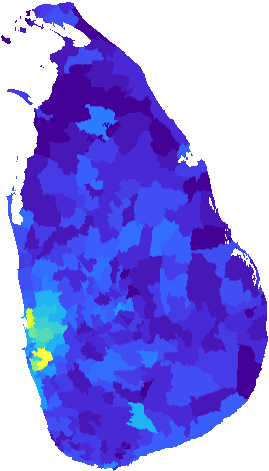
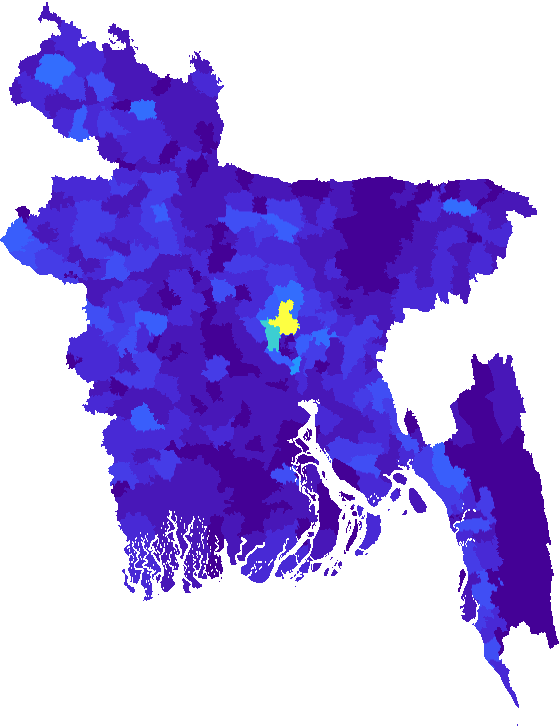

In [5]:
lka_admin0_shpfile_path = "_data/raw/lka_adm/lka_admbnda_adm0_slsd_20220816.shp"
lka_pop_footprints_path = "_data/clean/lka_footprints.tif"
bgd_admin0_shpfile_path = "_data/raw/bgd_adm/bgd_admbnda_adm0_bbs_20201113.shp"
bgd_pop_footprints_path = "_data/clean/bgd_footprints.tif"
# ind_admin0_shpfile_path = "_data/raw/ind_adm/adm0.shp"
# ind_pop_footprints_path = "_data/clean/ind_footprints.tif"

lka_admin_raw = gpd.read_file(lka_admin0_shpfile_path)
lka_footprints_raw = rio.open(lka_pop_footprints_path)
lka_bounding_box = lka_footprints_raw.bounds
lka_bounds = [[lka_bounding_box.bottom, lka_bounding_box.left], [lka_bounding_box.top, lka_bounding_box.right]]
lka_image, lka_transform = mask.mask(lka_footprints_raw, list(lka_admin_raw["geometry"][0].geoms), nodata = np.nan)
lka_image = lka_image[0]

bgd_admin_raw = gpd.read_file(bgd_admin0_shpfile_path)
bgd_footprints_raw = rio.open(bgd_pop_footprints_path)
bgd_bounding_box = bgd_footprints_raw.bounds
bgd_bounds = [[bgd_bounding_box.bottom, bgd_bounding_box.left], [bgd_bounding_box.top, bgd_bounding_box.right]]
bgd_image, bgd_transform = mask.mask(bgd_footprints_raw, list(bgd_admin_raw["geometry"][0].geoms), nodata = np.nan)
bgd_image = bgd_image[0]

all_shape = pd.concat((bgd_admin_raw, lka_admin_raw))
all_shape["all"] = 1
all_shape = all_shape[["all", "geometry"]].dissolve(by = "all").reset_index()
centroid_lon, centroid_lat = all_shape.centroid[0].coords.xy
centroid_lon, centroid_lat = centroid_lon[0], centroid_lat[0]

colormaps = []

for image, title in zip([lka_image, bgd_image], ["Sri Lanka", "Bangladesh"]):
    colormaps += [define_cmap(image, "Log-Population Density per Square Km - " + title)]

m = folium.Map(location=(centroid_lat, centroid_lon), zoom_start = 5)

for image, title, bounds, cmap in zip([lka_image, bgd_image], ["Sri Lanka", "Bangladesh"], [lka_bounds, bgd_bounds], colormaps):
    # overlay = folium.raster_layers.ImageOverlay(np.log10(image, out=np.zeros_like(image, dtype=np.float64), where=(image!=0)), opacity = .5, bounds = bounds, colormap = lambda x: mapvalue2color(x, cmap), name = title, mercator_project=True)
    overlay = folium.raster_layers.ImageOverlay(image, opacity = .5, bounds = bounds, colormap = lambda x: mapvalue2color(x, cmap), name = title, mercator_project=True)

    
    for child in overlay._children:
        if child.startswith("color_map"):
            del overlay._children[child]
    
    m.add_child(cmap)
    m.add_child(overlay)
    overlay_bind = BindColormap(overlay, cmap)
    m.add_child(overlay_bind)

m.add_child(folium.LayerControl())
m

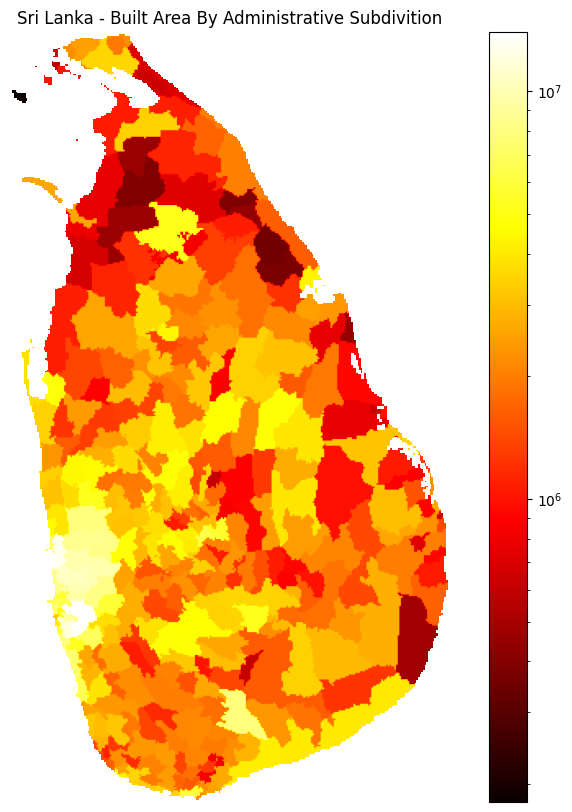

In [6]:
plt.figure(figsize = (10, 10))
plt.imshow(lka_image, cmap = "hot", norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.box(False)
plt.axis(False)
plt.title("Sri Lanka - Built Area By Administrative Subdivition")
plt.show()

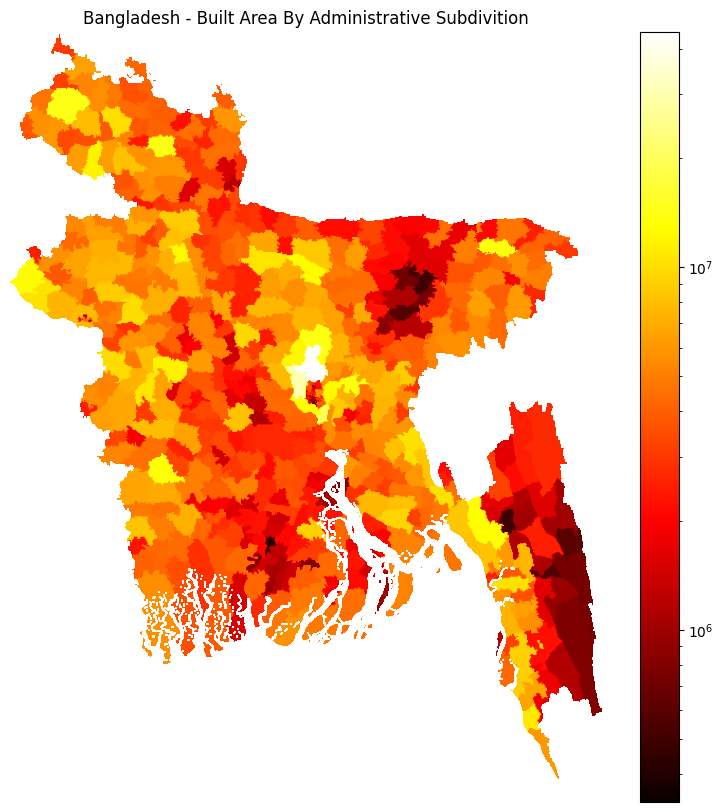

In [7]:
plt.figure(figsize = (10, 10))
plt.imshow(bgd_image, cmap = "hot", norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.box(False)
plt.axis(False)
plt.title("Bangladesh - Built Area By Administrative Subdivition")
plt.show()